In [104]:
from pymongo import MongoClient
import json
import requests
import pandas as pd
import plotly.express as px
from collections import OrderedDict

In [105]:
# Create client and load in Fraud database
client = MongoClient()
db = client["Fraud"]
fraud_data = db["FraudData"]

## Visualizations 

### Count of fraud transactions

In [106]:
# Group by if it is fraud, counting the number of transactions
stage_group_fraud = {
    "$group": {
        "_id": "$isFraud", 
        "count": {"$sum": 1}
    }
}

pipeline = [
    stage_group_fraud
]

count_fraud = fraud_data.aggregate(pipeline)
count_fraud = pd.DataFrame(list(count_fraud))

In [107]:
fig = px.bar(count_fraud,x="_id",y="count",
              labels={"amount": "Count","_id":"isFraud"},title="Count of fraudulent transactions")

In [108]:
fig.show()

### Count of transaction types

In [109]:
# Group by transaction type, counting the number of transactions
stage_group_trans = {
    "$group": {
        "_id": {
            "transaction_type": "$type"
        },
        "count": {"$sum": 1}
    }
}

stage_project = {
    "$project": {
        "transaction_type": "$_id.transaction_type",
        "count": "$count",
        "_id": 0
    }
}

pipeline = [
    stage_group_trans,
    stage_project
]

count_trans = fraud_data.aggregate(pipeline)
count_trans = pd.DataFrame(list(count_trans))

In [110]:
fig2 = px.bar(count_trans,x="transaction_type",y="count",
              labels={"count": "Count"},title="Count of each transaction type:")

In [111]:
fig2.show()

### Average amount by transaction type

In [112]:
# Group by transaction type
stage_group_trans = {
    "$group": {
        "_id": {
            "transaction_type": "$type"
        },
        "avg": {"$avg": "$amount"}
    }
}

stage_project = {
    "$project": {
        "transaction_type": "$_id.transaction_type",
        "avg": "$avg",
        "_id": 0
    }
}

stage_sort = {
    "$sort": OrderedDict([("transaction_type", 1), ("is_fraud", 1)])
}

pipeline = [
    stage_group_trans,
    stage_project,
    stage_sort
]

avg_by_type = fraud_data.aggregate(pipeline)
avg_by_type = pd.DataFrame(list(avg_by_type))

In [113]:
avg_by_type

,transaction_type,avg
0,CASH_IN,168920.242004
1,CASH_OUT,176273.964346
2,DEBIT,5483.665314
3,PAYMENT,13057.604660
4,TRANSFER,910647.009645


In [114]:
px.bar(avg_by_type,x="transaction_type",y="avg",
              labels={"avg": "Average","transaction_type":"Transaction Type"},title="Average amount by transaction type")

In [115]:
# Group by transaction type, fraud, counting the number of transactions
stage_group_trans = {
    "$group": {
        "_id": {
            "transaction_type": "$type",
            "is_fraud": "$isFraud"
        },
        "avg": {"$avg": "$amount"}
    }
}

stage_project = {
    "$project": {
        "transaction_type": "$_id.transaction_type",
        "is_fraud": "$_id.is_fraud",
        "avg": "$avg",
        "_id": 0
    }
}

stage_sort = {
    "$sort": OrderedDict([("transaction_type", 1), ("is_fraud", 1)])
}

pipeline = [
    stage_group_trans,
    stage_project,
    stage_sort
]

avg_by_isfraud = fraud_data.aggregate(pipeline)
avg_by_isfraud = pd.DataFrame(list(avg_by_isfraud))

In [116]:
fig6 = px.histogram(avg_by_isfraud, x="transaction_type", y="avg", title="Average amount by transaction type and fraud status",
             color='is_fraud', barmode='group',
             height=500)
fig6.show()

### Count of transaction types by isFraud 

In [117]:
# Group by transaction type, fraud, counting the number of transactions
stage_group_trans = {
    "$group": {
        "_id": {
            "transaction_type": "$type",
            "is_fraud": "$isFraud"
        },
        "count": {"$sum": 1}
    }
}

stage_project = {
    "$project": {
        "transaction_type": "$_id.transaction_type",
        "is_fraud": "$_id.is_fraud",
        "count": "$count",
        "_id": 0
    }
}

stage_sort = {
    "$sort": OrderedDict([("transaction_type", 1), ("is_fraud", 1)])
}

pipeline = [
    stage_group_trans,
    stage_project,
    stage_sort
]

count_type_fraud = fraud_data.aggregate(pipeline)
count_type_fraud = pd.DataFrame(list(count_type_fraud))

In [118]:
fig4 = px.histogram(count_type_fraud, x="transaction_type", y="count", title="All transaction type counts, by fraud status",
             color='is_fraud', barmode='group',
             height=500)
fig4.show()

In [119]:
fraud_types_only = count_type_fraud[(count_type_fraud['transaction_type']=='CASH_OUT') | (count_type_fraud['transaction_type']=='TRANSFER')]

In [120]:
fig5 = px.histogram(fraud_types_only, x="transaction_type", y="count", title="Transfer and Cashout counts by Fraud Status",
             color='is_fraud', barmode='group',
             height=500)
fig5.show()

### General distribution for each type for model input types (only those where isFraud can equal 1)

In [121]:
# Filter only for payment transactions that are TRANSFER or CASH_OUT
stage_filter_trans = {
    "$match": {
        "type": {"$in": ["TRANSFER", "CASH_OUT"]},
    }
}

stage_project = {
    "$project": {
        "is_transfer": {
            "$cond": { 
                "if": {"$eq": ["$type", "TRANSFER"]}, "then": 1, "else": 0}
        },
        "oldBalanceOrig":"$oldbalanceOrg",
        "amount": "$amount",
        "isFraud": "$isFraud",
        "isFlaggedFraud":"$isFlaggedFraud",
        "_id": 0
    }
}

pipeline = [
    stage_filter_trans,
    stage_project
]

results = fraud_data.aggregate(pipeline)

In [122]:
results = pd.DataFrame(list(results))

In [123]:
results

,is_transfer,oldBalanceOrig,amount,isFraud,isFlaggedFraud
0,0,15325.00,229133.94,0,0
1,0,181.00,181.00,1,0
2,1,181.00,181.00,1,0
3,1,705.00,215310.30,0,0
4,1,10835.00,311685.89,0,0
...,...,...,...,...,...
2770404,1,6311409.28,6311409.28,1,0
2770405,0,339682.13,339682.13,1,0
2770406,0,6311409.28,6311409.28,1,0
2770407,1,850002.52,850002.52,1,0


In [124]:
transfer_amts=results[results['is_transfer']==1]
cashout_amts=results[results['is_transfer']==0]

### Transfer distribution

In [125]:
pd.DataFrame(round(transfer_amts['amount'].describe(),2))

,amount
count,532909.00
mean,910647.01
std,1879573.53
min,2.60
25%,215905.35
50%,486308.39
75%,974958.00
max,92445516.64


In [126]:
pd.DataFrame(round(transfer_amts['oldBalanceOrig'].describe(),2))

,oldBalanceOrig
count,532909.00
mean,54441.85
std,439981.78
min,0.00
25%,0.00
50%,0.00
75%,26266.00
max,59585040.37


<AxesSubplot:>

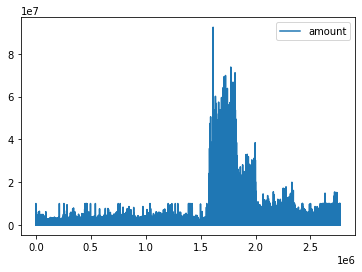

In [127]:
transfer_amts.plot(y='amount')

<AxesSubplot:>

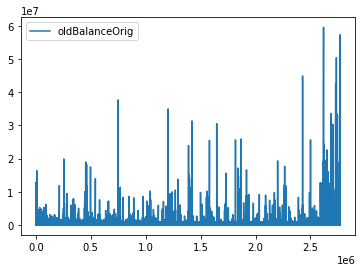

In [128]:
transfer_amts.plot(y='oldBalanceOrig')

### Cashout distribution

In [129]:
pd.DataFrame(round(cashout_amts['amount'].describe(),2))

,amount
count,2237500.00
mean,176273.96
std,175329.74
min,0.00
25%,72669.65
50%,147072.18
75%,246539.48
max,10000000.00


In [130]:
pd.DataFrame(round(cashout_amts['oldBalanceOrig'].describe(),2))

,oldBalanceOrig
count,2237500.00
mean,46023.80
std,179132.64
min,0.00
25%,0.00
50%,556.00
75%,31446.24
max,43818855.30


<AxesSubplot:>

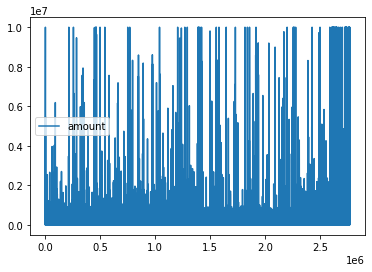

In [131]:
cashout_amts.plot(y='amount')

<AxesSubplot:>

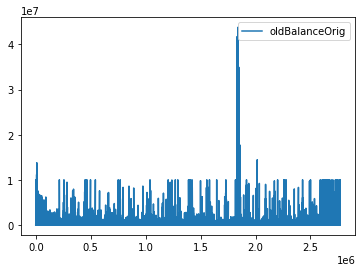

In [132]:
cashout_amts.plot(y='oldBalanceOrig')

In [133]:
nonfraud_transfer = transfer_amts[transfer_amts['isFraud']==0]
fraud_transfer = transfer_amts[transfer_amts['isFraud']==1]
nonfraud_cashout = cashout_amts[cashout_amts['isFraud']==0]
fraud_cashout = cashout_amts[cashout_amts['isFraud']==1]

### Non-fraud transfer histograms

In [134]:
import matplotlib.pyplot as plt
import numpy as np

In [135]:
pd.DataFrame(round(nonfraud_transfer['amount'].describe(),2))

,amount
count,528812.00
mean,906229.01
std,1874155.26
min,2.60
25%,216570.76
50%,486521.91
75%,972733.64
max,92445516.64


In [136]:
pd.DataFrame(round(nonfraud_transfer['oldBalanceOrig'].describe(),2))

,oldBalanceOrig
count,528812.00
mean,40558.76
std,140618.55
min,0.00
25%,0.00
50%,0.00
75%,24854.00
max,25908675.06


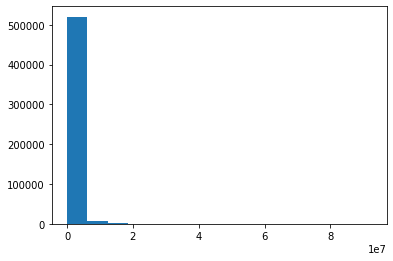

In [137]:
fig6 = plt.hist(np.array(nonfraud_transfer['amount']), bins=15)

In [161]:
for f in fig6[1]:
    print(round(f,2))

2.6
6163036.87
12326071.14
18489105.41
24652139.68
30815173.95
36978208.22
43141242.49
49304276.75
55467311.02
61630345.29
67793379.56
73956413.83
80119448.1
86282482.37
92445516.64


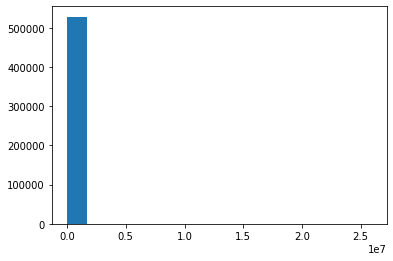

In [138]:
fig7 = plt.hist(np.array(nonfraud_transfer['oldBalanceOrig']), bins=15)

In [139]:
nf_trans_max = nonfraud_transfer['amount'].max()

In [140]:
nonfraud_transfer[nonfraud_transfer['amount']==nf_trans_max]

,is_transfer,oldBalanceOrig,amount,isFraud,isFlaggedFraud
1614118,1,0.0,92445516.64,0,0


### Fraud transfer histograms

In [141]:
pd.DataFrame(round(fraud_transfer['amount'].describe(),2))

,amount
count,4097.00
mean,1480891.67
std,2414890.38
min,63.80
25%,128417.96
50%,445705.76
75%,1534985.07
max,10000000.00


In [142]:
pd.DataFrame(round(fraud_transfer['oldBalanceOrig'].describe(),2))

,oldBalanceOrig
count,4097.00
mean,1846374.19
std,4404157.37
min,0.00
25%,127564.33
50%,444898.97
75%,1534985.07
max,59585040.37


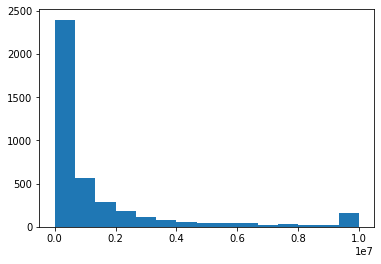

In [143]:
fig8 = plt.hist(np.array(fraud_transfer['amount']), bins=15)

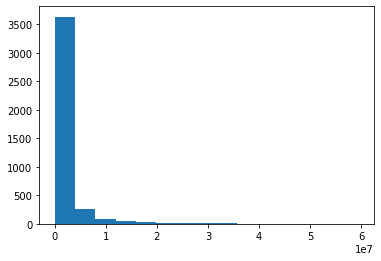

In [144]:
fig9 = plt.hist(np.array(fraud_transfer['oldBalanceOrig']), bins=15)

### Non-fraud cashout histogram

In [145]:
pd.DataFrame(round(nonfraud_cashout['amount'].describe(),2))

,amount
count,2233384.00
mean,173917.16
std,131222.24
min,0.01
25%,72627.69
50%,146946.56
75%,246181.18
max,2847566.62


In [146]:
pd.DataFrame(round(nonfraud_cashout['oldBalanceOrig'].describe(),2))

,oldBalanceOrig
count,2233384.00
mean,43429.23
std,133880.16
min,0.00
25%,0.00
50%,539.00
75%,31327.04
max,43818855.30


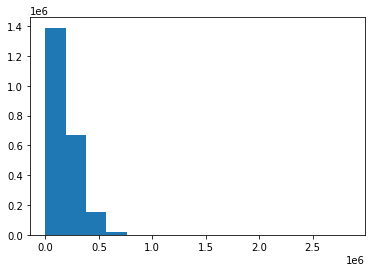

In [147]:
fig10 = plt.hist(np.array(nonfraud_cashout['amount']), bins=15)

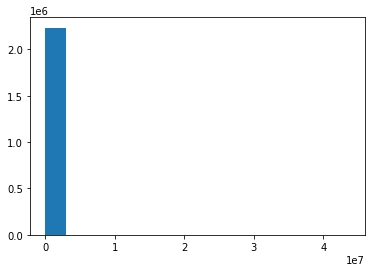

In [148]:
fig11 = plt.hist(np.array(nonfraud_cashout['oldBalanceOrig']), bins=15)

In [154]:
fig11

(array([2.233119e+06, 2.350000e+02, 1.800000e+01, 2.000000e+00,
        3.000000e+00, 2.000000e+00, 1.000000e+00, 0.000000e+00,
        1.000000e+00, 0.000000e+00, 0.000000e+00, 1.000000e+00,
        0.000000e+00, 0.000000e+00, 2.000000e+00]),
 array([       0.  ,  2921257.02,  5842514.04,  8763771.06, 11685028.08,
        14606285.1 , 17527542.12, 20448799.14, 23370056.16, 26291313.18,
        29212570.2 , 32133827.22, 35055084.24, 37976341.26, 40897598.28,
        43818855.3 ]),
 <BarContainer object of 15 artists>)

### Fraud cashout histogram

In [149]:
pd.DataFrame(round(fraud_cashout['amount'].describe(),2))

,amount
count,4116.00
mean,1455102.59
std,2393841.79
min,0.00
25%,125464.45
50%,435516.90
75%,1500761.03
max,10000000.00


In [150]:
pd.DataFrame(round(fraud_cashout['oldBalanceOrig'].describe(),2))

,oldBalanceOrig
count,4116.00
mean,1453869.05
std,2394505.61
min,0.00
25%,123231.00
50%,433677.74
75%,1500761.03
max,10000000.00


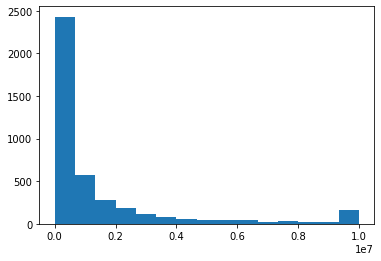

In [151]:
fig12 = plt.hist(np.array(fraud_cashout['amount']), bins=15)

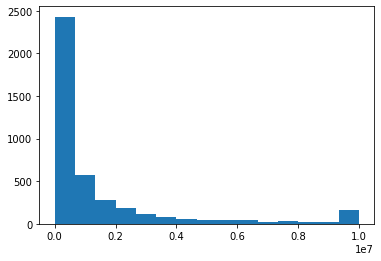

In [153]:
fig13 = plt.hist(np.array(fraud_cashout['oldBalanceOrig']), bins=15)